In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import csv
import torchvision

In [2]:
# Set a fixed seed for reproducibility across random number generators in Python, NumPy, and PyTorch (CPU/GPU), ensuring consistent results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
# Define a basic residual block with two convolutional layers and a shortcut connection for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, planes * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Implement a ResNet architecture with configurable blocks and layers for image classification
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(block, 32,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Create a small ResNet model using BasicBlock with predefined layer configuration for 10-class classification
def ResNetSmall():
    return ResNet(BasicBlock, [4, 4, 4, 3], num_classes=10)

In [5]:
# Initialize the ResNetSmall model, move it to the specified device, and compute parameter count and summary
model = ResNetSmall().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model param count: {num_params:,}")

# Print a detailed model summary (requires torchinfo)
from torchsummary import summary
summary(model, input_size=(3, 32, 32))  # Assuming input size e.g., CIFAR-10 (3, 32, 32)

Model param count: 4,754,218
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      Batc

In [6]:
# Define normalization constants and data augmentation transforms for CIFAR-10, then load train/test datasets and create DataLoaders
MEAN = [0.4914, 0.4822, 0.4465]
STD  = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_dataset = datasets.CIFAR10(root="./data", train=True,
                                 download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False,
                                 download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)

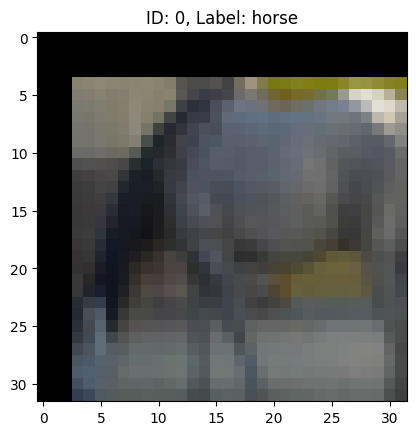

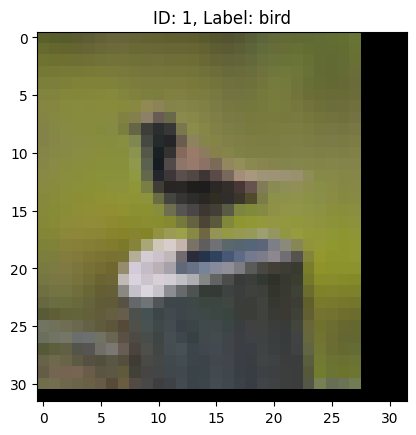

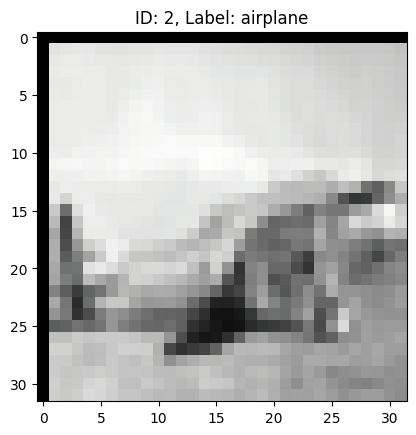

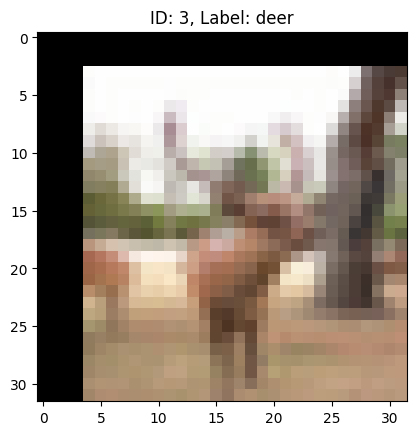

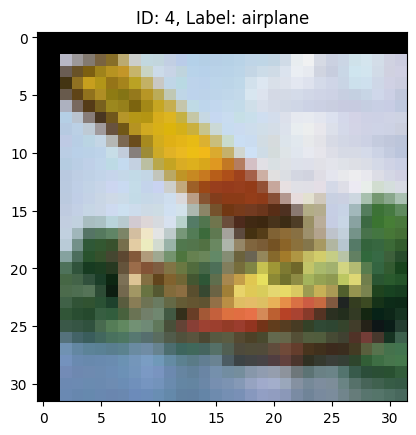

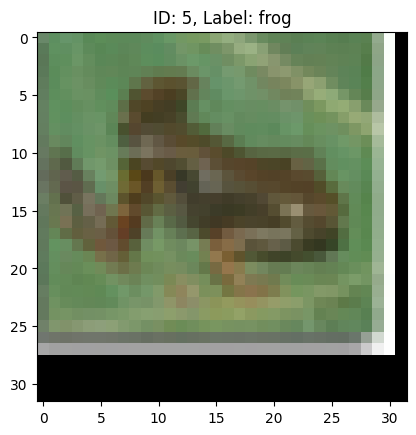

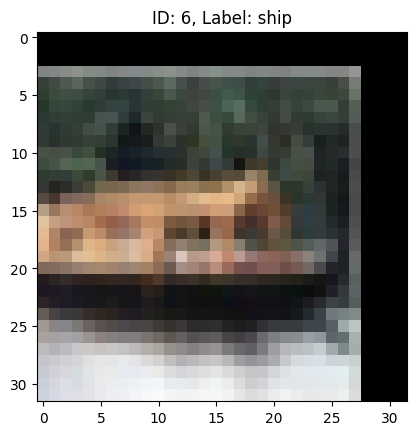

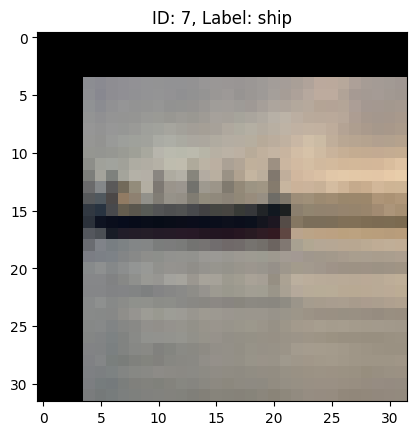

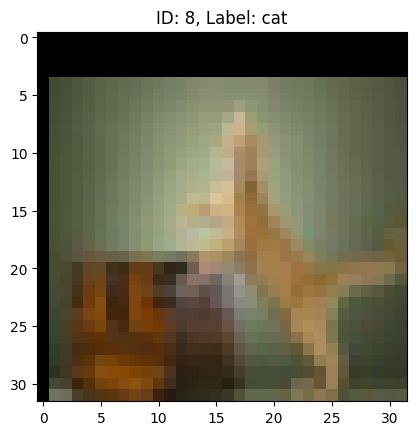

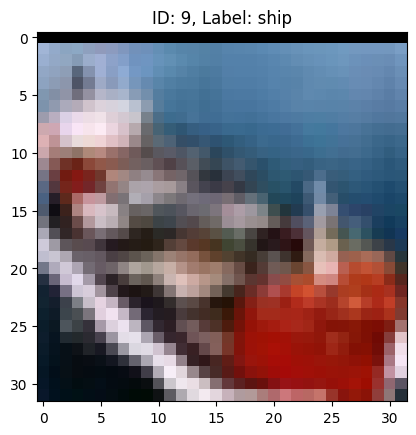

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
images, labels = next(iter(train_loader))

# Define the 10 class labels for the CIFAR-10 dataset
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

# Display each image individually
for i in range(10):
    # Denormalize the image
    image = images[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Display the image with ID and label
    plt.figure()
    plt.imshow(image)
    plt.title(f"ID: {i}, Label: {classes[labels[i]]}")
    plt.show()

In [8]:
# Train the model for one epoch, compute loss and accuracy, and update weights using the optimizer
def train(model, loader, optimizer, criterion):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to device (e.g., GPU)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * imgs.size(0)  # Accumulate loss (scaled by batch size)
        _, pred = outputs.max(1)  # Get predicted class
        correct += pred.eq(labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total samples

    epoch_loss = running_loss / total  # Average loss per sample
    epoch_acc = 100.0 * correct / total  # Accuracy percentage
    train_losses.append(epoch_loss)  # Store for tracking
    train_accs.append(epoch_acc)
    return epoch_loss, epoch_acc

# Evaluate the model on a validation/test set, compute loss and accuracy without gradient updates
def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to device

            outputs = model(imgs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            running_loss += loss.item() * imgs.size(0)  # Accumulate loss
            _, pred = outputs.max(1)  # Get predicted class
            correct += pred.eq(labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples

    epoch_loss = running_loss / total  # Average loss per sample
    epoch_acc = 100.0 * correct / total  # Accuracy percentage
    val_losses.append(epoch_loss)  # Store for tracking
    val_accs.append(epoch_acc)
    return epoch_loss, epoch_acc

In [9]:
# Define the loss function, SGD optimizer with momentum and weight decay, and a multi-step learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

In [11]:
# Initialize lists to track training and validation metrics, then train the model for multiple epochs while saving the best model based on validation accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []

EPOCHS = 100
best_acc = 0.0

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    scheduler.step()  # Update learning rate based on scheduler

    if val_acc > best_acc:  # Save model if validation accuracy improves
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_ResNet.pth")

    print(f"Epoch [{epoch+1:03d}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Test Loss: {val_loss:.4f} | Test Acc: {val_acc:.2f}%")

print("\nTraining complete!")
print(f"Best Test Accuracy: {best_acc:.2f}%")

Epoch [001/100] Train Loss: 1.2819 | Train Acc: 53.62% || Test Loss: 1.2968 | Test Acc: 54.06%
Epoch [002/100] Train Loss: 1.1008 | Train Acc: 60.76% || Test Loss: 1.0698 | Test Acc: 62.17%
Epoch [003/100] Train Loss: 0.9517 | Train Acc: 66.66% || Test Loss: 1.0695 | Test Acc: 62.42%
Epoch [004/100] Train Loss: 0.8372 | Train Acc: 70.57% || Test Loss: 0.8547 | Test Acc: 70.46%
Epoch [005/100] Train Loss: 0.7284 | Train Acc: 74.65% || Test Loss: 0.8512 | Test Acc: 71.17%
Epoch [006/100] Train Loss: 0.6574 | Train Acc: 77.21% || Test Loss: 0.7050 | Test Acc: 75.73%
Epoch [007/100] Train Loss: 0.6179 | Train Acc: 78.70% || Test Loss: 0.7112 | Test Acc: 76.79%
Epoch [008/100] Train Loss: 0.5804 | Train Acc: 79.98% || Test Loss: 0.6362 | Test Acc: 78.18%
Epoch [009/100] Train Loss: 0.5613 | Train Acc: 80.69% || Test Loss: 0.6607 | Test Acc: 78.32%
Epoch [010/100] Train Loss: 0.5322 | Train Acc: 81.83% || Test Loss: 0.5934 | Test Acc: 79.45%
Epoch [011/100] Train Loss: 0.5163 | Train Acc: 82

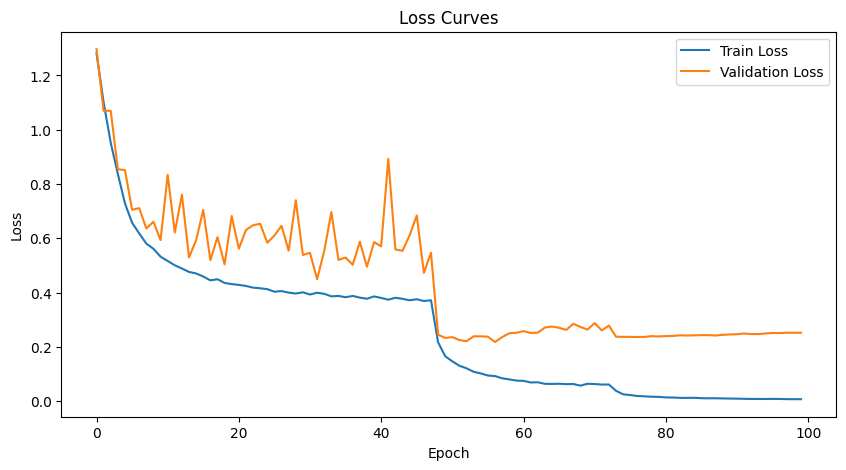

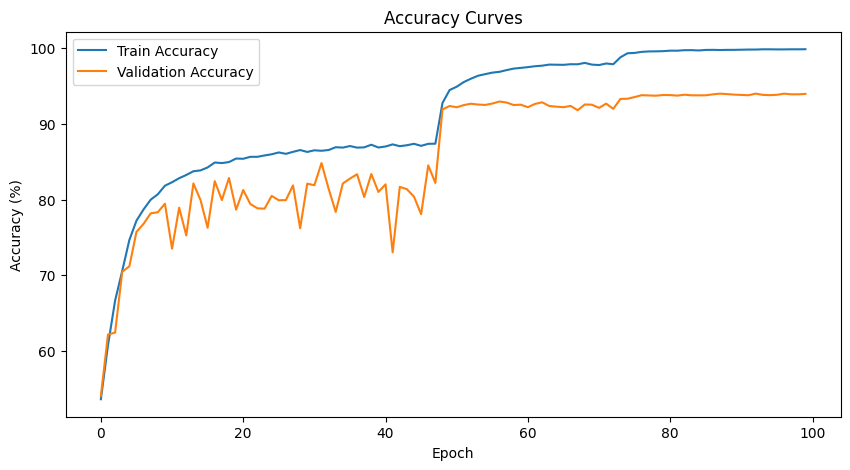

In [12]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

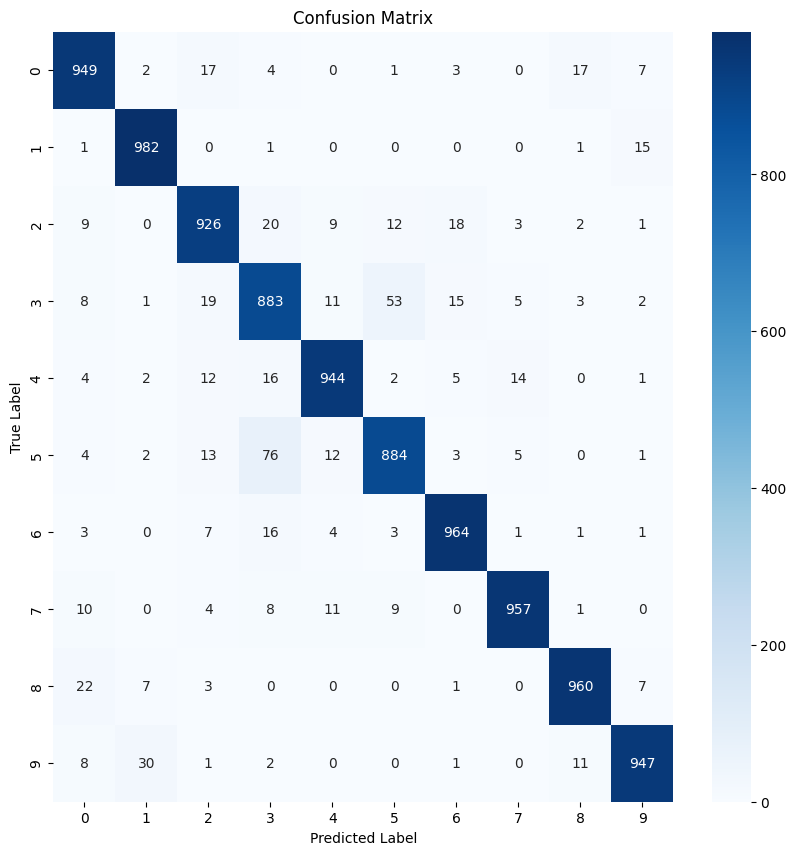

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
from PIL import ImageFilter
import random

# Define a custom Gaussian blur function and a comprehensive training transform pipeline for CIFAR-10 with data augmentation
def gaussian_blur(img):
    radius = random.uniform(0.1, 1.5)  # Random blur radius between 0.1 and 1.5
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),              # Randomly crop with padding
    transforms.RandomHorizontalFlip(),                 # 50% chance of horizontal flip
    transforms.RandomApply([
        transforms.Lambda(gaussian_blur)               # Apply Gaussian blur with 30% probability
    ], p=0.3),
    transforms.RandomVerticalFlip(p=0.05),             # 5% chance of vertical flip
    transforms.ToTensor(),                             # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),     # Normalize with CIFAR-10 mean and std
                         (0.2470, 0.2435, 0.2616)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)) # 50% chance of erasing a small region
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [24]:
# CutMix implementation
def cutmix_data(x, y, alpha=1.0):
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    # Sample from beta distribution
    lam = np.random.beta(alpha, alpha)

    # Define the bounding box coordinates
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    # Perform CutMix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    # Create mixed target
    y_a, y_b = y, y[index]

    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [28]:
cutmix_prob = 0.5
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply CutMix with probability cutmix_prob
        if np.random.rand() < cutmix_prob:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            # For accuracy calculation during CutMix
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (lam * predicted.eq(targets_a).sum().float() +
                       (1 - lam) * predicted.eq(targets_b).sum().float()).item()
        else:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Standard accuracy calculation
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    return train_loss, 100.*correct/total

# Validation function
def validate(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss, 100.*correct/total

In [14]:
num_epochs = 200
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
batch_size = 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler to improve convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
best_acc = 0

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f'\nEpoch: {epoch+1}/{num_epochs} | LR: {current_lr:.6f}')

    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)

    # Update learning rate
    scheduler.step()

    # Save metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_acc:
        print(f'Saving checkpoint... Validation accuracy improved from {best_acc:.3f}% to {val_acc:.3f}%')
        state = {
            'model': model.state_dict(),
            'acc': val_acc,
            'epoch': epoch,
        }
        torch.save(state, 'resnet_cifar10_best.pth')
        best_acc = val_acc

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy: {best_acc:.3f}%')


Epoch: 1/200 | LR: 0.010000
Epoch 0, Train Loss: 1.0856, Train Accuracy: 65.24%
Epoch 0, Val Loss: 0.6537, Val Accuracy: 77.98%
Saving checkpoint... Validation accuracy improved from 0.000% to 77.980%
Train Loss: 1.0856 | Train Acc: 65.24% | Val Loss: 0.6537 | Val Acc: 77.98%

Epoch: 2/200 | LR: 0.009999
Epoch 1, Train Loss: 1.0459, Train Accuracy: 66.79%
Epoch 1, Val Loss: 0.6250, Val Accuracy: 79.50%
Saving checkpoint... Validation accuracy improved from 77.980% to 79.500%
Train Loss: 1.0459 | Train Acc: 66.79% | Val Loss: 0.6250 | Val Acc: 79.50%

Epoch: 3/200 | LR: 0.009998
Epoch 2, Train Loss: 1.0101, Train Accuracy: 67.75%
Epoch 2, Val Loss: 0.5866, Val Accuracy: 79.57%
Saving checkpoint... Validation accuracy improved from 79.500% to 79.570%
Train Loss: 1.0101 | Train Acc: 67.75% | Val Loss: 0.5866 | Val Acc: 79.57%

Epoch: 4/200 | LR: 0.009994
Epoch 3, Train Loss: 0.9405, Train Accuracy: 69.88%
Epoch 3, Val Loss: 0.5559, Val Accuracy: 81.31%
Saving checkpoint... Validation acc

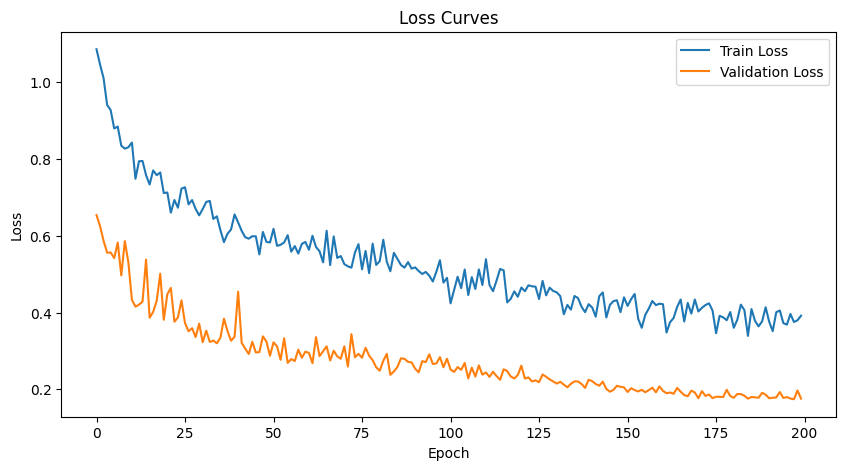

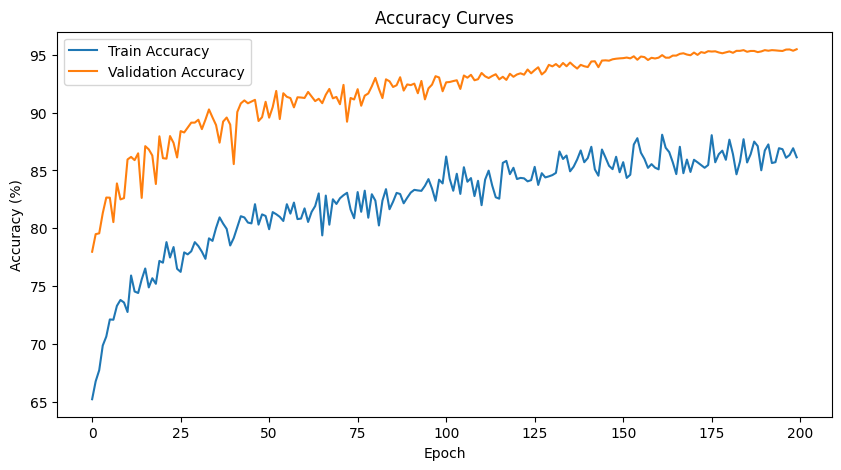

In [25]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("optimized_loss_curve.jpeg")
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("optimized_accuracy_curve.jpeg")
plt.show()

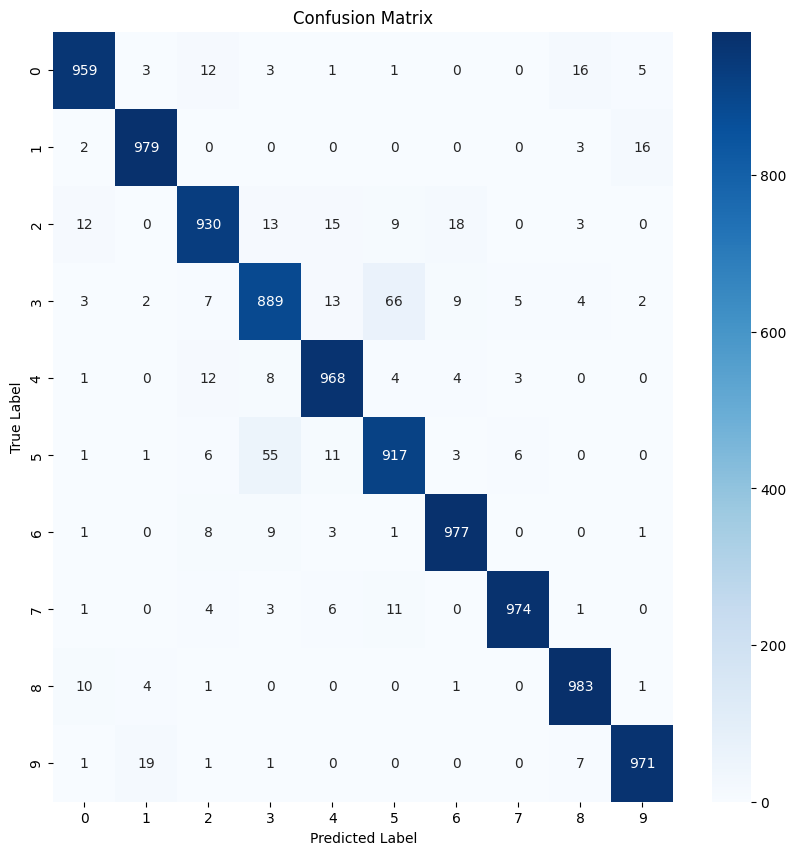

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("optimized_conf.jpeg")
plt.show()

In [33]:
import torch
import pickle
import csv
import numpy as np
from torchvision import transforms
from PIL import Image

# Your training normalization values
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_test_path = "cifar_test_nolabel.pkl"

# Define Gaussian blur function (assuming you have this from training)
def gaussian_blur(img):
    from scipy.ndimage import gaussian_filter
    img_np = np.array(img)
    blurred = gaussian_filter(img_np, sigma=1.0)
    return Image.fromarray(blurred.astype(np.uint8))

# TTA transformations based on training augmentations
tta_transforms = [
    # Base transformation (no augmentation)
    transforms.ToTensor(),
    # Horizontal flip (deterministic)
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    # Crop (center crop after padding, deterministic version of RandomCrop)
    transforms.Compose([transforms.Pad(4), transforms.CenterCrop(32), transforms.ToTensor()]),
    # Gaussian blur
    transforms.Compose([transforms.Lambda(gaussian_blur), transforms.ToTensor()]),
    # Vertical flip (deterministic)
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]),
]

def custom_transform(img_np):
    """Base transformation for normalization"""
    if img_np.shape == (3*32*32,):
        img_np = img_np.reshape(3,32,32).transpose(1,2,0)
    img_np = img_np.transpose(2,0,1)  # To CHW format
    tensor_img = torch.from_numpy(img_np).float() / 255.0
    for i in range(3):
        tensor_img[i,:,:] = (tensor_img[i,:,:] - MEAN[i]) / STD[i]
    return tensor_img

# Load data and make predictions
try:
    with open(custom_test_path, 'rb') as f:
        custom_test_data = pickle.load(f)

    unlabeled_imgs = custom_test_data[b'data']
    unlabeled_ids = custom_test_data[b'ids']

    # Assuming model = ResNet18_mini().to(device) is already defined
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(len(unlabeled_imgs)):
            # Convert to proper format
            img_np = unlabeled_imgs[i]
            if img_np.shape == (3*32*32,):
                img_np = img_np.reshape(3,32,32).transpose(1,2,0)
            img_np = img_np.astype(np.uint8)  # For PIL compatibility

            # Store predictions from all augmentations
            tta_outputs = []

            # Apply each TTA transformation
            for tta_transform in tta_transforms:
                # Convert numpy to PIL Image for transforms
                img_pil = Image.fromarray(img_np)
                aug_img = tta_transform(img_pil)

                # Apply normalization
                for j in range(3):
                    aug_img[j,:,:] = (aug_img[j,:,:] - MEAN[j]) / STD[j]

                aug_img = aug_img.unsqueeze(0).to(device)
                output = model(aug_img)
                tta_outputs.append(output)

            # Average predictions across all augmentations
            avg_output = torch.mean(torch.stack(tta_outputs), dim=0)
            _, pred_label = torch.max(avg_output, 1)
            predictions.append((unlabeled_ids[i], pred_label.item()))

    # Write CSV
    csv_filename = "submission_tta.csv"
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["ID", "Labels"])
        for (img_id, label) in predictions:
            writer.writerow([img_id, label])

    print(f"CSV saved as '{csv_filename}' with {len(predictions)} entries.")

except Exception as e:
    print(f"An error occurred: {str(e)}")

CSV saved as 'submission_tta.csv' with 10000 entries.


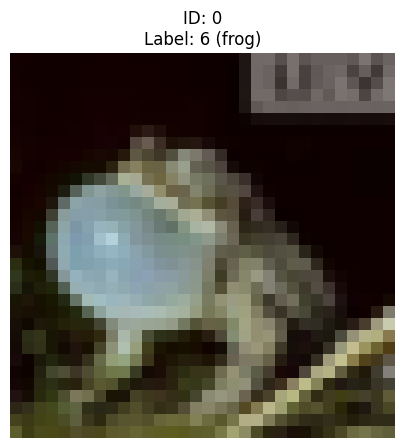

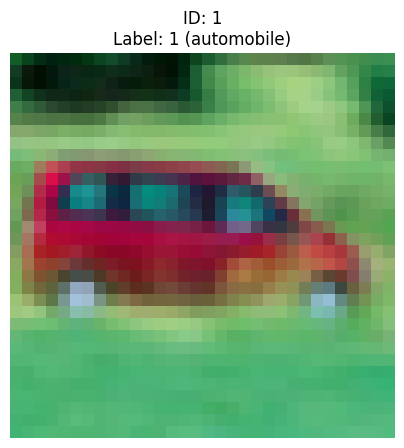

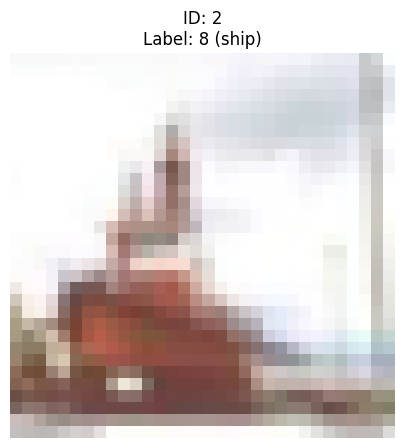

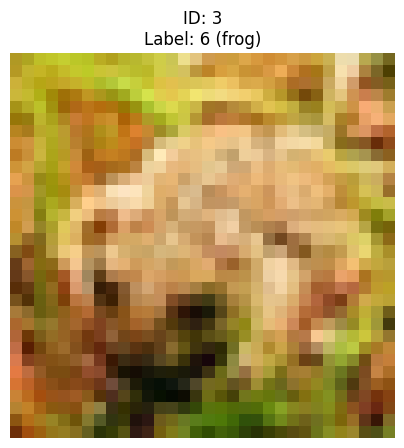

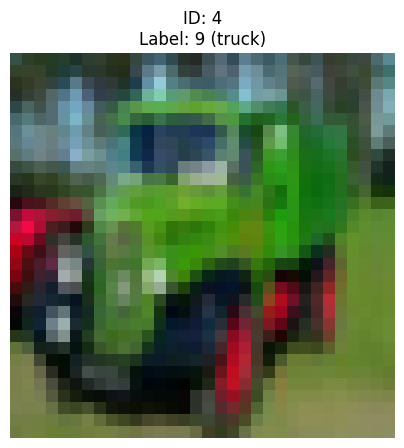

Displayed 5 images with predicted labels.


In [34]:
import torch
import pickle
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# CIFAR-10 class names
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Your training normalization values
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_test_path = "cifar_test_nolabel.pkl"

# Define Gaussian blur function
def gaussian_blur(img):
    from scipy.ndimage import gaussian_filter
    img_np = np.array(img)
    blurred = gaussian_filter(img_np, sigma=1.0)
    return Image.fromarray(blurred.astype(np.uint8))

# TTA transformations
tta_transforms = [
    transforms.ToTensor(),
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    transforms.Compose([transforms.Pad(4), transforms.CenterCrop(32), transforms.ToTensor()]),
    transforms.Compose([transforms.Lambda(gaussian_blur), transforms.ToTensor()]),
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]),
]

def custom_transform(img_np):
    if img_np.shape == (3*32*32,):
        img_np = img_np.reshape(3,32,32).transpose(1,2,0)
    img_np = img_np.transpose(2,0,1)
    tensor_img = torch.from_numpy(img_np).float() / 255.0
    for i in range(3):
        tensor_img[i,:,:] = (tensor_img[i,:,:] - MEAN[i]) / STD[i]
    return tensor_img

# Function to unnormalize image for display
def unnormalize(img_tensor):
    img = img_tensor.clone().cpu()
    for i in range(3):
        img[i,:,:] = (img[i,:,:] * STD[i]) + MEAN[i]
    return img.numpy().transpose(1, 2, 0).clip(0, 1)

try:
    # Load the test data
    with open(custom_test_path, 'rb') as f:
        custom_test_data = pickle.load(f)

    unlabeled_imgs = custom_test_data[b'data']
    unlabeled_ids = custom_test_data[b'ids']

    # Assuming model = ResNet18_mini().to(device) is defined and trained
    model.eval()

    num_to_display = 5  # Number of images to display

    with torch.no_grad():
        for i in range(min(num_to_display, len(unlabeled_imgs))):  # Show first 5 images
            img_np = unlabeled_imgs[i]
            if img_np.shape == (3*32*32,):
                img_np = img_np.reshape(3,32,32).transpose(1,2,0)
            img_np = img_np.astype(np.uint8)

            # TTA predictions
            tta_outputs = []
            for tta_transform in tta_transforms:
                img_pil = Image.fromarray(img_np)
                aug_img = tta_transform(img_pil)
                for j in range(3):
                    aug_img[j,:,:] = (aug_img[j,:,:] - MEAN[j]) / STD[j]
                aug_img = aug_img.unsqueeze(0).to(device)
                output = model(aug_img)
                tta_outputs.append(output)

            # Average predictions
            avg_output = torch.mean(torch.stack(tta_outputs), dim=0)
            _, pred_label = torch.max(avg_output, 1)
            pred_label = pred_label.item()

            # Display image with label and class name
            display_img = unnormalize(custom_transform(unlabeled_imgs[i]))
            plt.figure(figsize=(5, 5))
            plt.imshow(display_img)
            plt.title(f"ID: {unlabeled_ids[i]}\nLabel: {pred_label} ({CIFAR10_CLASSES[pred_label]})")
            plt.axis('off')
            plt.show()

    print(f"Displayed {min(num_to_display, len(unlabeled_imgs))} images with predicted labels.")

except Exception as e:
    print(f"An error occurred: {str(e)}")